In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import os
from torch.utils.data import Dataset, DataLoader
import torch
import cv2
from skimage import io
from PIL import Image


def make_class_to_index(csv_file):
    labels = pd.read_csv(csv_file)
    classes = list(labels["race"].unique())
    idx_to_class = {i: j for i, j in enumerate(classes)}
    class_to_idx = {value: key for key, value in idx_to_class.items()}
    return class_to_idx


class FairFaceDataset(Dataset):
    """Fair Face dataset."""

    def __init__(self, csv_file, root_dir, class_to_idx, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.labels = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.class_to_idx = class_to_idx

    def __len__(self):
        return len(self.labels)

    def get_classes(self):
        return self.class_to_idx

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                os.path.basename(self.labels.iloc[idx, 0]))

        # image = cv2.imread(img_name)
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.open(img_name)
        #image = Image.fromarray(image)
        label = self.labels.iloc[idx, 3]
        label = self.class_to_idx[label]

        if self.transform is not None:
            image = self.transform(image)

        return image, label


def gen_dataloader(data_folder, csv_file, transformers, batch_size, class_to_idx):
    face_dataset = FairFaceDataset(csv_file=csv_file, root_dir=data_folder,
                                   transform=transformers, class_to_idx=class_to_idx)
    dataloader = DataLoader(face_dataset, batch_size=batch_size,
                            shuffle=True, num_workers=0)
    return dataloader, len(face_dataset), face_dataset.get_classes()


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch


def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


def visualize_model(model, dataloaders, device, class_names, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [4]:
from torchvision import models
import torch
from torchvision import transforms
from PIL import Image
#from dataset_loader import gen_dataloader
import time
import copy
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import os
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

In [5]:
writer = SummaryWriter()

In [6]:
writer_val = SummaryWriter()

In [7]:
train_data_path = "../input/fairface/FairFace/train"
val_data_path = "../input/fairface/FairFace/val"
models_path = "./models/"
train_labels_path = "../input/fairface/FairFace/train_labels.csv"
val_labels_path = "../input/fairface/FairFace/val_labels.csv"

In [8]:
data_transforms = {
    'train': transforms.Compose([
        #transforms.ToPILImage(),
        transforms.Resize(224), # проверить кроп 
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        #transforms.ToPILImage(),
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [10]:
class_to_idx = make_class_to_index(train_labels_path)
train_dataloader, train_size, classes = gen_dataloader(train_data_path, train_labels_path,
                            transformers=data_transforms["train"], batch_size=128, class_to_idx=class_to_idx)
print(classes)

test_dataloader, val_size, classes = gen_dataloader(val_data_path, val_labels_path,
                            transformers=data_transforms["val"], batch_size=128, class_to_idx=class_to_idx)
print(classes)

dataloaders = {
    "train": train_dataloader,
    "val": test_dataloader
}
dataset_sizes = {'train': train_size, 'val': val_size}
dataset_sizes

{'East Asian': 0, 'Indian': 1, 'Black': 2, 'White': 3, 'Middle Eastern': 4, 'Latino_Hispanic': 5, 'Southeast Asian': 6}
{'East Asian': 0, 'Indian': 1, 'Black': 2, 'White': 3, 'Middle Eastern': 4, 'Latino_Hispanic': 5, 'Southeast Asian': 6}


{'train': 86744, 'val': 10954}

In [11]:
model_ft = models.resnet34(pretrained=True)
# for param in model_ft.parameters():
#     param.requires_grad = False
n = model_ft.fc.in_features
model_ft.fc = nn.Sequential(
    nn.Linear(n, 128),
    nn.ReLU(inplace=True),
    nn.Linear(128, len(classes))).to(device)
# model_ft.fc = nn.Linear(model_ft.fc.in_features, len(classes))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.000001) # Проверить lr/ переделать на adam

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1) # Попробовать убрать
exp_lr_scheduler = None
optimizer = optimizer_ft
net = model_ft

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [12]:
n_epochs = 25
print_every = 10
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_dataloader)
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in tqdm(enumerate(train_dataloader)):
        data_, target_ = data_.to(device), target_.to(device)
        optimizer.zero_grad()
        
        outputs = net(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    writer.add_scalar("Loss/train", running_loss/total_step, epoch)
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        net.eval()
        for data_t, target_t in tqdm((test_dataloader)):
            data_t, target_t = data_t.to(device), target_t.to(device)
            outputs_t = net(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t/total_t)
        val_loss.append(batch_loss/len(test_dataloader))
        writer_val.add_scalar("Loss/val", batch_loss/len(test_dataloader), epoch)
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')

        
        if network_learned:
            valid_loss_min = batch_loss
            torch.save(net.state_dict(), 'resnet34_00009lr_full.pt')
            # torch.save(net, os.path.join(models_path, "resnet34_best.pth"))
            print('Improvement-Detected, save-model')
    net.train()

Epoch 1



1it [00:07,  7.40s/it]

Epoch [1/25], Step [0/678], Loss: 2.0178


21it [00:27,  1.01s/it]

Epoch [1/25], Step [20/678], Loss: 2.0002


41it [00:48,  1.02s/it]

Epoch [1/25], Step [40/678], Loss: 1.9879


61it [01:08,  1.02it/s]

Epoch [1/25], Step [60/678], Loss: 1.9316


81it [01:28,  1.03s/it]

Epoch [1/25], Step [80/678], Loss: 1.9369


101it [01:48,  1.01it/s]

Epoch [1/25], Step [100/678], Loss: 1.9446


121it [02:09,  1.00it/s]

Epoch [1/25], Step [120/678], Loss: 1.9088


141it [02:29,  1.03s/it]

Epoch [1/25], Step [140/678], Loss: 1.9410


161it [02:49,  1.02s/it]

Epoch [1/25], Step [160/678], Loss: 1.9119


181it [03:09,  1.03it/s]

Epoch [1/25], Step [180/678], Loss: 1.9220


201it [03:29,  1.01it/s]

Epoch [1/25], Step [200/678], Loss: 1.8985


221it [03:49,  1.01s/it]

Epoch [1/25], Step [220/678], Loss: 1.9142


241it [04:09,  1.00s/it]

Epoch [1/25], Step [240/678], Loss: 1.9312


261it [04:29,  1.00s/it]

Epoch [1/25], Step [260/678], Loss: 1.9486


281it [04:49,  1.01it/s]

Epoch [1/25], Step [280/678], Loss: 1.9018


301it [05:10,  1.01it/s]

Epoch [1/25], Step [300/678], Loss: 1.9029


321it [05:30,  1.03s/it]

Epoch [1/25], Step [320/678], Loss: 1.9263


341it [05:50,  1.01it/s]

Epoch [1/25], Step [340/678], Loss: 1.9147


361it [06:11,  1.02s/it]

Epoch [1/25], Step [360/678], Loss: 1.9459


381it [06:31,  1.02s/it]

Epoch [1/25], Step [380/678], Loss: 1.8702


401it [06:51,  1.02s/it]

Epoch [1/25], Step [400/678], Loss: 1.8554


421it [07:12,  1.00s/it]

Epoch [1/25], Step [420/678], Loss: 1.8986


441it [07:32,  1.01s/it]

Epoch [1/25], Step [440/678], Loss: 1.8850


461it [07:52,  1.01it/s]

Epoch [1/25], Step [460/678], Loss: 1.8773


481it [08:12,  1.00s/it]

Epoch [1/25], Step [480/678], Loss: 1.8614


501it [08:32,  1.04s/it]

Epoch [1/25], Step [500/678], Loss: 1.9083


521it [08:52,  1.01s/it]

Epoch [1/25], Step [520/678], Loss: 1.8563


541it [09:12,  1.01it/s]

Epoch [1/25], Step [540/678], Loss: 1.8795


561it [09:32,  1.01s/it]

Epoch [1/25], Step [560/678], Loss: 1.8915


581it [09:53,  1.03s/it]

Epoch [1/25], Step [580/678], Loss: 1.8121


601it [10:13,  1.01it/s]

Epoch [1/25], Step [600/678], Loss: 1.8660


621it [10:33,  1.01it/s]

Epoch [1/25], Step [620/678], Loss: 1.8774


641it [10:53,  1.05s/it]

Epoch [1/25], Step [640/678], Loss: 1.8362


661it [11:13,  1.02s/it]

Epoch [1/25], Step [660/678], Loss: 1.8554


678it [11:30,  1.02s/it]



train-loss: 1.9122, train-acc: 22.4384


100%|██████████| 86/86 [01:09<00:00,  1.23it/s]


validation loss: 1.8482, validation acc: 29.2496

Improvement-Detected, save-model
Epoch 2



1it [00:00,  1.42it/s]

Epoch [2/25], Step [0/678], Loss: 1.8392


21it [00:15,  1.34it/s]

Epoch [2/25], Step [20/678], Loss: 1.8344


41it [00:29,  1.43it/s]

Epoch [2/25], Step [40/678], Loss: 1.8175


61it [00:43,  1.43it/s]

Epoch [2/25], Step [60/678], Loss: 1.8419


81it [00:57,  1.41it/s]

Epoch [2/25], Step [80/678], Loss: 1.8520


101it [01:12,  1.38it/s]

Epoch [2/25], Step [100/678], Loss: 1.8477


121it [01:26,  1.41it/s]

Epoch [2/25], Step [120/678], Loss: 1.8022


141it [01:41,  1.36it/s]

Epoch [2/25], Step [140/678], Loss: 1.8215


161it [01:55,  1.40it/s]

Epoch [2/25], Step [160/678], Loss: 1.8129


181it [02:09,  1.45it/s]

Epoch [2/25], Step [180/678], Loss: 1.7767


201it [02:24,  1.44it/s]

Epoch [2/25], Step [200/678], Loss: 1.7702


221it [02:38,  1.42it/s]

Epoch [2/25], Step [220/678], Loss: 1.7954


241it [02:52,  1.44it/s]

Epoch [2/25], Step [240/678], Loss: 1.8226


261it [03:06,  1.46it/s]

Epoch [2/25], Step [260/678], Loss: 1.7485


281it [03:20,  1.40it/s]

Epoch [2/25], Step [280/678], Loss: 1.7884


301it [03:34,  1.42it/s]

Epoch [2/25], Step [300/678], Loss: 1.7677


321it [03:48,  1.35it/s]

Epoch [2/25], Step [320/678], Loss: 1.7746


341it [04:03,  1.41it/s]

Epoch [2/25], Step [340/678], Loss: 1.7572


361it [04:17,  1.41it/s]

Epoch [2/25], Step [360/678], Loss: 1.7252


381it [04:31,  1.45it/s]

Epoch [2/25], Step [380/678], Loss: 1.6737


401it [04:45,  1.43it/s]

Epoch [2/25], Step [400/678], Loss: 1.7811


421it [05:00,  1.38it/s]

Epoch [2/25], Step [420/678], Loss: 1.7265


441it [05:14,  1.42it/s]

Epoch [2/25], Step [440/678], Loss: 1.6891


461it [05:28,  1.40it/s]

Epoch [2/25], Step [460/678], Loss: 1.7142


481it [05:42,  1.42it/s]

Epoch [2/25], Step [480/678], Loss: 1.7527


501it [05:57,  1.33it/s]

Epoch [2/25], Step [500/678], Loss: 1.7897


521it [06:11,  1.43it/s]

Epoch [2/25], Step [520/678], Loss: 1.7503


541it [06:25,  1.40it/s]

Epoch [2/25], Step [540/678], Loss: 1.7543


561it [06:40,  1.38it/s]

Epoch [2/25], Step [560/678], Loss: 1.6774


581it [06:53,  1.43it/s]

Epoch [2/25], Step [580/678], Loss: 1.6370


601it [07:08,  1.40it/s]

Epoch [2/25], Step [600/678], Loss: 1.6442


621it [07:22,  1.44it/s]

Epoch [2/25], Step [620/678], Loss: 1.7104


641it [07:36,  1.41it/s]

Epoch [2/25], Step [640/678], Loss: 1.6478


661it [07:50,  1.43it/s]

Epoch [2/25], Step [660/678], Loss: 1.7242


678it [08:02,  1.41it/s]



train-loss: 1.8376, train-acc: 34.3436


100%|██████████| 86/86 [00:42<00:00,  2.04it/s]


validation loss: 1.7587, validation acc: 38.9903

Improvement-Detected, save-model
Epoch 3



1it [00:00,  1.45it/s]

Epoch [3/25], Step [0/678], Loss: 1.7011


21it [00:14,  1.47it/s]

Epoch [3/25], Step [20/678], Loss: 1.6831


41it [00:28,  1.37it/s]

Epoch [3/25], Step [40/678], Loss: 1.6106


61it [00:42,  1.43it/s]

Epoch [3/25], Step [60/678], Loss: 1.6181


81it [00:56,  1.43it/s]

Epoch [3/25], Step [80/678], Loss: 1.7074


101it [01:10,  1.46it/s]

Epoch [3/25], Step [100/678], Loss: 1.5958


121it [01:25,  1.23it/s]

Epoch [3/25], Step [120/678], Loss: 1.7156


141it [01:39,  1.46it/s]

Epoch [3/25], Step [140/678], Loss: 1.6718


161it [01:53,  1.45it/s]

Epoch [3/25], Step [160/678], Loss: 1.6353


181it [02:07,  1.37it/s]

Epoch [3/25], Step [180/678], Loss: 1.5977


201it [02:21,  1.44it/s]

Epoch [3/25], Step [200/678], Loss: 1.6603


221it [02:35,  1.42it/s]

Epoch [3/25], Step [220/678], Loss: 1.5948


241it [02:49,  1.45it/s]

Epoch [3/25], Step [240/678], Loss: 1.5723


261it [03:03,  1.39it/s]

Epoch [3/25], Step [260/678], Loss: 1.6382


281it [03:17,  1.47it/s]

Epoch [3/25], Step [280/678], Loss: 1.5262


301it [03:31,  1.31it/s]

Epoch [3/25], Step [300/678], Loss: 1.6481


321it [03:45,  1.44it/s]

Epoch [3/25], Step [320/678], Loss: 1.5474


341it [03:59,  1.44it/s]

Epoch [3/25], Step [340/678], Loss: 1.6525


361it [04:12,  1.47it/s]

Epoch [3/25], Step [360/678], Loss: 1.4943


381it [04:26,  1.42it/s]

Epoch [3/25], Step [380/678], Loss: 1.5943


401it [04:41,  1.42it/s]

Epoch [3/25], Step [400/678], Loss: 1.5957


421it [04:55,  1.47it/s]

Epoch [3/25], Step [420/678], Loss: 1.5406


441it [05:09,  1.43it/s]

Epoch [3/25], Step [440/678], Loss: 1.4983


461it [05:23,  1.46it/s]

Epoch [3/25], Step [460/678], Loss: 1.5356


481it [05:37,  1.41it/s]

Epoch [3/25], Step [480/678], Loss: 1.5682


501it [05:51,  1.45it/s]

Epoch [3/25], Step [500/678], Loss: 1.5846


521it [06:05,  1.40it/s]

Epoch [3/25], Step [520/678], Loss: 1.4617


541it [06:19,  1.44it/s]

Epoch [3/25], Step [540/678], Loss: 1.4726


561it [06:33,  1.40it/s]

Epoch [3/25], Step [560/678], Loss: 1.5232


581it [06:47,  1.46it/s]

Epoch [3/25], Step [580/678], Loss: 1.4971


601it [07:01,  1.47it/s]

Epoch [3/25], Step [600/678], Loss: 1.4835


621it [07:15,  1.38it/s]

Epoch [3/25], Step [620/678], Loss: 1.5813


641it [07:29,  1.42it/s]

Epoch [3/25], Step [640/678], Loss: 1.5103


661it [07:43,  1.45it/s]

Epoch [3/25], Step [660/678], Loss: 1.4477


678it [07:55,  1.43it/s]



train-loss: 1.7542, train-acc: 42.0513


100%|██████████| 86/86 [00:39<00:00,  2.19it/s]


validation loss: 1.6742, validation acc: 44.8056

Improvement-Detected, save-model
Epoch 4



1it [00:00,  1.43it/s]

Epoch [4/25], Step [0/678], Loss: 1.5255


21it [00:14,  1.39it/s]

Epoch [4/25], Step [20/678], Loss: 1.5300


41it [00:28,  1.45it/s]

Epoch [4/25], Step [40/678], Loss: 1.4315


61it [00:41,  1.39it/s]

Epoch [4/25], Step [60/678], Loss: 1.5278


81it [00:55,  1.43it/s]

Epoch [4/25], Step [80/678], Loss: 1.5085


101it [01:09,  1.46it/s]

Epoch [4/25], Step [100/678], Loss: 1.4715


121it [01:23,  1.46it/s]

Epoch [4/25], Step [120/678], Loss: 1.4857


141it [01:37,  1.44it/s]

Epoch [4/25], Step [140/678], Loss: 1.5232


161it [01:51,  1.40it/s]

Epoch [4/25], Step [160/678], Loss: 1.4642


181it [02:05,  1.47it/s]

Epoch [4/25], Step [180/678], Loss: 1.3964


201it [02:19,  1.46it/s]

Epoch [4/25], Step [200/678], Loss: 1.3966


221it [02:33,  1.43it/s]

Epoch [4/25], Step [220/678], Loss: 1.3773


241it [02:47,  1.46it/s]

Epoch [4/25], Step [240/678], Loss: 1.4182


261it [03:01,  1.45it/s]

Epoch [4/25], Step [260/678], Loss: 1.4250


281it [03:14,  1.45it/s]

Epoch [4/25], Step [280/678], Loss: 1.4075


301it [03:28,  1.43it/s]

Epoch [4/25], Step [300/678], Loss: 1.4295


321it [03:42,  1.48it/s]

Epoch [4/25], Step [320/678], Loss: 1.4477


341it [03:56,  1.37it/s]

Epoch [4/25], Step [340/678], Loss: 1.4079


361it [04:10,  1.47it/s]

Epoch [4/25], Step [360/678], Loss: 1.3886


381it [04:24,  1.45it/s]

Epoch [4/25], Step [380/678], Loss: 1.4366


401it [04:37,  1.48it/s]

Epoch [4/25], Step [400/678], Loss: 1.4920


421it [04:51,  1.45it/s]

Epoch [4/25], Step [420/678], Loss: 1.4650


441it [05:05,  1.42it/s]

Epoch [4/25], Step [440/678], Loss: 1.4316


461it [05:19,  1.46it/s]

Epoch [4/25], Step [460/678], Loss: 1.3892


481it [05:33,  1.39it/s]

Epoch [4/25], Step [480/678], Loss: 1.3075


501it [05:47,  1.48it/s]

Epoch [4/25], Step [500/678], Loss: 1.4071


521it [06:01,  1.40it/s]

Epoch [4/25], Step [520/678], Loss: 1.3392


541it [06:15,  1.45it/s]

Epoch [4/25], Step [540/678], Loss: 1.4306


561it [06:28,  1.46it/s]

Epoch [4/25], Step [560/678], Loss: 1.4327


581it [06:42,  1.47it/s]

Epoch [4/25], Step [580/678], Loss: 1.3072


601it [06:56,  1.39it/s]

Epoch [4/25], Step [600/678], Loss: 1.3794


621it [07:10,  1.43it/s]

Epoch [4/25], Step [620/678], Loss: 1.4236


641it [07:24,  1.46it/s]

Epoch [4/25], Step [640/678], Loss: 1.4098


661it [07:38,  1.46it/s]

Epoch [4/25], Step [660/678], Loss: 1.3431


678it [07:49,  1.44it/s]



train-loss: 1.6761, train-acc: 46.9715


100%|██████████| 86/86 [00:39<00:00,  2.16it/s]


validation loss: 1.6010, validation acc: 48.9136

Improvement-Detected, save-model
Epoch 5



1it [00:00,  1.40it/s]

Epoch [5/25], Step [0/678], Loss: 1.3857


21it [00:14,  1.41it/s]

Epoch [5/25], Step [20/678], Loss: 1.3508


41it [00:28,  1.42it/s]

Epoch [5/25], Step [40/678], Loss: 1.3821


61it [00:42,  1.47it/s]

Epoch [5/25], Step [60/678], Loss: 1.4042


81it [00:56,  1.47it/s]

Epoch [5/25], Step [80/678], Loss: 1.4205


101it [01:09,  1.48it/s]

Epoch [5/25], Step [100/678], Loss: 1.3819


121it [01:23,  1.45it/s]

Epoch [5/25], Step [120/678], Loss: 1.4176


141it [01:37,  1.44it/s]

Epoch [5/25], Step [140/678], Loss: 1.2939


161it [01:51,  1.43it/s]

Epoch [5/25], Step [160/678], Loss: 1.2994


181it [02:05,  1.43it/s]

Epoch [5/25], Step [180/678], Loss: 1.2903


201it [02:20,  1.25it/s]

Epoch [5/25], Step [200/678], Loss: 1.3302


221it [02:34,  1.47it/s]

Epoch [5/25], Step [220/678], Loss: 1.3718


241it [02:48,  1.45it/s]

Epoch [5/25], Step [240/678], Loss: 1.2407


261it [03:02,  1.42it/s]

Epoch [5/25], Step [260/678], Loss: 1.3490


281it [03:16,  1.45it/s]

Epoch [5/25], Step [280/678], Loss: 1.3906


301it [03:30,  1.43it/s]

Epoch [5/25], Step [300/678], Loss: 1.2566


321it [03:44,  1.43it/s]

Epoch [5/25], Step [320/678], Loss: 1.3111


341it [03:58,  1.41it/s]

Epoch [5/25], Step [340/678], Loss: 1.4046


361it [04:12,  1.48it/s]

Epoch [5/25], Step [360/678], Loss: 1.3478


381it [04:26,  1.47it/s]

Epoch [5/25], Step [380/678], Loss: 1.4101


401it [04:40,  1.39it/s]

Epoch [5/25], Step [400/678], Loss: 1.3333


421it [04:53,  1.47it/s]

Epoch [5/25], Step [420/678], Loss: 1.3394


441it [05:07,  1.46it/s]

Epoch [5/25], Step [440/678], Loss: 1.3432


461it [05:21,  1.47it/s]

Epoch [5/25], Step [460/678], Loss: 1.2832


481it [05:35,  1.42it/s]

Epoch [5/25], Step [480/678], Loss: 1.2914


501it [05:49,  1.47it/s]

Epoch [5/25], Step [500/678], Loss: 1.3501


521it [06:03,  1.37it/s]

Epoch [5/25], Step [520/678], Loss: 1.3962


541it [06:17,  1.47it/s]

Epoch [5/25], Step [540/678], Loss: 1.2388


561it [06:31,  1.42it/s]

Epoch [5/25], Step [560/678], Loss: 1.3871


581it [06:45,  1.42it/s]

Epoch [5/25], Step [580/678], Loss: 1.2618


601it [06:59,  1.44it/s]

Epoch [5/25], Step [600/678], Loss: 1.3212


621it [07:13,  1.41it/s]

Epoch [5/25], Step [620/678], Loss: 1.3091


641it [07:27,  1.43it/s]

Epoch [5/25], Step [640/678], Loss: 1.3563


661it [07:41,  1.44it/s]

Epoch [5/25], Step [660/678], Loss: 1.2357


678it [07:52,  1.43it/s]



train-loss: 1.6078, train-acc: 50.4830


100%|██████████| 86/86 [00:43<00:00,  1.99it/s]


validation loss: 1.5387, validation acc: 52.0997

Improvement-Detected, save-model
Epoch 6



1it [00:00,  1.43it/s]

Epoch [6/25], Step [0/678], Loss: 1.2877


21it [00:15,  1.43it/s]

Epoch [6/25], Step [20/678], Loss: 1.3220


41it [00:29,  1.41it/s]

Epoch [6/25], Step [40/678], Loss: 1.1922


61it [00:43,  1.43it/s]

Epoch [6/25], Step [60/678], Loss: 1.3079


81it [00:57,  1.43it/s]

Epoch [6/25], Step [80/678], Loss: 1.3590


101it [01:11,  1.28it/s]

Epoch [6/25], Step [100/678], Loss: 1.2873


121it [01:25,  1.43it/s]

Epoch [6/25], Step [120/678], Loss: 1.2484


141it [01:39,  1.41it/s]

Epoch [6/25], Step [140/678], Loss: 1.2108


161it [01:54,  1.44it/s]

Epoch [6/25], Step [160/678], Loss: 1.2434


181it [02:08,  1.41it/s]

Epoch [6/25], Step [180/678], Loss: 1.2581


201it [02:22,  1.44it/s]

Epoch [6/25], Step [200/678], Loss: 1.2402


221it [02:36,  1.41it/s]

Epoch [6/25], Step [220/678], Loss: 1.2216


241it [02:50,  1.36it/s]

Epoch [6/25], Step [240/678], Loss: 1.1520


261it [03:04,  1.42it/s]

Epoch [6/25], Step [260/678], Loss: 1.3440


281it [03:19,  1.44it/s]

Epoch [6/25], Step [280/678], Loss: 1.2365


301it [03:33,  1.41it/s]

Epoch [6/25], Step [300/678], Loss: 1.1684


321it [03:47,  1.28it/s]

Epoch [6/25], Step [320/678], Loss: 1.2370


341it [04:01,  1.46it/s]

Epoch [6/25], Step [340/678], Loss: 1.1616


361it [04:16,  1.40it/s]

Epoch [6/25], Step [360/678], Loss: 1.3272


381it [04:30,  1.38it/s]

Epoch [6/25], Step [380/678], Loss: 1.3336


401it [04:44,  1.45it/s]

Epoch [6/25], Step [400/678], Loss: 1.2057


421it [04:58,  1.43it/s]

Epoch [6/25], Step [420/678], Loss: 1.2820


441it [05:12,  1.46it/s]

Epoch [6/25], Step [440/678], Loss: 1.2839


461it [05:27,  1.41it/s]

Epoch [6/25], Step [460/678], Loss: 1.1699


481it [05:41,  1.43it/s]

Epoch [6/25], Step [480/678], Loss: 1.2727


501it [05:55,  1.36it/s]

Epoch [6/25], Step [500/678], Loss: 1.2826


521it [06:09,  1.40it/s]

Epoch [6/25], Step [520/678], Loss: 1.1853


541it [06:24,  1.43it/s]

Epoch [6/25], Step [540/678], Loss: 1.2741


561it [06:38,  1.40it/s]

Epoch [6/25], Step [560/678], Loss: 1.1550


581it [06:52,  1.36it/s]

Epoch [6/25], Step [580/678], Loss: 1.2889


601it [07:06,  1.40it/s]

Epoch [6/25], Step [600/678], Loss: 1.1850


621it [07:20,  1.45it/s]

Epoch [6/25], Step [620/678], Loss: 1.2371


641it [07:35,  1.44it/s]

Epoch [6/25], Step [640/678], Loss: 1.1886


661it [07:49,  1.38it/s]

Epoch [6/25], Step [660/678], Loss: 1.1119


678it [08:01,  1.41it/s]



train-loss: 1.5490, train-acc: 53.2164


100%|██████████| 86/86 [00:43<00:00,  1.97it/s]


validation loss: 1.4868, validation acc: 54.3820

Improvement-Detected, save-model
Epoch 7



1it [00:00,  1.40it/s]

Epoch [7/25], Step [0/678], Loss: 1.1195


21it [00:15,  1.43it/s]

Epoch [7/25], Step [20/678], Loss: 1.2304


41it [00:29,  1.44it/s]

Epoch [7/25], Step [40/678], Loss: 1.3045


61it [00:43,  1.43it/s]

Epoch [7/25], Step [60/678], Loss: 1.2216


81it [00:58,  1.38it/s]

Epoch [7/25], Step [80/678], Loss: 1.2766


101it [01:12,  1.44it/s]

Epoch [7/25], Step [100/678], Loss: 1.2750


121it [01:27,  1.36it/s]

Epoch [7/25], Step [120/678], Loss: 1.1511


141it [01:41,  1.43it/s]

Epoch [7/25], Step [140/678], Loss: 1.2019


161it [01:55,  1.38it/s]

Epoch [7/25], Step [160/678], Loss: 1.2705


181it [02:10,  1.34it/s]

Epoch [7/25], Step [180/678], Loss: 1.2464


201it [02:24,  1.46it/s]

Epoch [7/25], Step [200/678], Loss: 1.1638


221it [02:38,  1.35it/s]

Epoch [7/25], Step [220/678], Loss: 1.1520


241it [02:52,  1.44it/s]

Epoch [7/25], Step [240/678], Loss: 1.3377


261it [03:07,  1.38it/s]

Epoch [7/25], Step [260/678], Loss: 1.1993


281it [03:21,  1.43it/s]

Epoch [7/25], Step [280/678], Loss: 1.1860


301it [03:35,  1.39it/s]

Epoch [7/25], Step [300/678], Loss: 1.2426


321it [03:49,  1.40it/s]

Epoch [7/25], Step [320/678], Loss: 1.1020


341it [04:04,  1.33it/s]

Epoch [7/25], Step [340/678], Loss: 1.2117


361it [04:18,  1.45it/s]

Epoch [7/25], Step [360/678], Loss: 1.2106


381it [04:32,  1.35it/s]

Epoch [7/25], Step [380/678], Loss: 1.2349


401it [04:47,  1.45it/s]

Epoch [7/25], Step [400/678], Loss: 1.1477


421it [05:01,  1.41it/s]

Epoch [7/25], Step [420/678], Loss: 1.1550


441it [05:15,  1.43it/s]

Epoch [7/25], Step [440/678], Loss: 1.1214


461it [05:29,  1.40it/s]

Epoch [7/25], Step [460/678], Loss: 1.1203


481it [05:44,  1.39it/s]

Epoch [7/25], Step [480/678], Loss: 1.1711


501it [05:58,  1.46it/s]

Epoch [7/25], Step [500/678], Loss: 1.2912


521it [06:13,  1.31it/s]

Epoch [7/25], Step [520/678], Loss: 1.2546


541it [06:27,  1.46it/s]

Epoch [7/25], Step [540/678], Loss: 1.0318


561it [06:41,  1.45it/s]

Epoch [7/25], Step [560/678], Loss: 1.1380


581it [06:55,  1.38it/s]

Epoch [7/25], Step [580/678], Loss: 1.2349


601it [07:09,  1.44it/s]

Epoch [7/25], Step [600/678], Loss: 1.1637


621it [07:23,  1.43it/s]

Epoch [7/25], Step [620/678], Loss: 1.1659


641it [07:37,  1.44it/s]

Epoch [7/25], Step [640/678], Loss: 1.1598


661it [07:52,  1.41it/s]

Epoch [7/25], Step [660/678], Loss: 1.2678


678it [08:03,  1.40it/s]



train-loss: 1.4985, train-acc: 55.4090


100%|██████████| 86/86 [00:39<00:00,  2.15it/s]


validation loss: 1.4426, validation acc: 55.9522

Improvement-Detected, save-model
Epoch 8



1it [00:00,  1.47it/s]

Epoch [8/25], Step [0/678], Loss: 1.2758


21it [00:14,  1.44it/s]

Epoch [8/25], Step [20/678], Loss: 1.1531


41it [00:28,  1.47it/s]

Epoch [8/25], Step [40/678], Loss: 1.3301


61it [00:42,  1.46it/s]

Epoch [8/25], Step [60/678], Loss: 1.1433


81it [00:56,  1.38it/s]

Epoch [8/25], Step [80/678], Loss: 1.2036


101it [01:10,  1.36it/s]

Epoch [8/25], Step [100/678], Loss: 1.1609


121it [01:24,  1.45it/s]

Epoch [8/25], Step [120/678], Loss: 1.2943


141it [01:38,  1.35it/s]

Epoch [8/25], Step [140/678], Loss: 1.2007


161it [01:53,  1.40it/s]

Epoch [8/25], Step [160/678], Loss: 1.1148


181it [02:07,  1.42it/s]

Epoch [8/25], Step [180/678], Loss: 1.1469


201it [02:21,  1.43it/s]

Epoch [8/25], Step [200/678], Loss: 1.0647


221it [02:35,  1.38it/s]

Epoch [8/25], Step [220/678], Loss: 1.1703


241it [02:49,  1.44it/s]

Epoch [8/25], Step [240/678], Loss: 1.2526


261it [03:03,  1.47it/s]

Epoch [8/25], Step [260/678], Loss: 1.0432


281it [03:17,  1.36it/s]

Epoch [8/25], Step [280/678], Loss: 1.0338


301it [03:31,  1.43it/s]

Epoch [8/25], Step [300/678], Loss: 1.2181


321it [03:45,  1.45it/s]

Epoch [8/25], Step [320/678], Loss: 1.3083


341it [03:59,  1.47it/s]

Epoch [8/25], Step [340/678], Loss: 1.1081


361it [04:13,  1.44it/s]

Epoch [8/25], Step [360/678], Loss: 1.2789


381it [04:27,  1.45it/s]

Epoch [8/25], Step [380/678], Loss: 1.1385


401it [04:41,  1.47it/s]

Epoch [8/25], Step [400/678], Loss: 1.2303


421it [04:55,  1.40it/s]

Epoch [8/25], Step [420/678], Loss: 1.1907


441it [05:09,  1.43it/s]

Epoch [8/25], Step [440/678], Loss: 1.1154


461it [05:22,  1.45it/s]

Epoch [8/25], Step [460/678], Loss: 1.0974


481it [05:36,  1.48it/s]

Epoch [8/25], Step [480/678], Loss: 1.0354


501it [05:50,  1.46it/s]

Epoch [8/25], Step [500/678], Loss: 1.0762


521it [06:04,  1.41it/s]

Epoch [8/25], Step [520/678], Loss: 1.0981


541it [06:18,  1.40it/s]

Epoch [8/25], Step [540/678], Loss: 1.1503


561it [06:32,  1.46it/s]

Epoch [8/25], Step [560/678], Loss: 0.9918


581it [06:46,  1.39it/s]

Epoch [8/25], Step [580/678], Loss: 1.0818


601it [07:00,  1.30it/s]

Epoch [8/25], Step [600/678], Loss: 1.1318


621it [07:14,  1.45it/s]

Epoch [8/25], Step [620/678], Loss: 1.1468


641it [07:28,  1.46it/s]

Epoch [8/25], Step [640/678], Loss: 1.0462


661it [07:42,  1.46it/s]

Epoch [8/25], Step [660/678], Loss: 1.2390


678it [07:54,  1.43it/s]



train-loss: 1.4547, train-acc: 56.9492


100%|██████████| 86/86 [00:42<00:00,  2.00it/s]


validation loss: 1.4047, validation acc: 57.0842

Improvement-Detected, save-model
Epoch 9



1it [00:00,  1.20it/s]

Epoch [9/25], Step [0/678], Loss: 1.1524


21it [00:15,  1.40it/s]

Epoch [9/25], Step [20/678], Loss: 1.1577


41it [00:29,  1.35it/s]

Epoch [9/25], Step [40/678], Loss: 1.0153


61it [00:43,  1.37it/s]

Epoch [9/25], Step [60/678], Loss: 1.2487


81it [00:57,  1.41it/s]

Epoch [9/25], Step [80/678], Loss: 1.1136


101it [01:11,  1.44it/s]

Epoch [9/25], Step [100/678], Loss: 1.1028


121it [01:25,  1.48it/s]

Epoch [9/25], Step [120/678], Loss: 1.1431


141it [01:39,  1.38it/s]

Epoch [9/25], Step [140/678], Loss: 1.1993


161it [01:53,  1.46it/s]

Epoch [9/25], Step [160/678], Loss: 1.0002


181it [02:07,  1.42it/s]

Epoch [9/25], Step [180/678], Loss: 1.1002


201it [02:21,  1.45it/s]

Epoch [9/25], Step [200/678], Loss: 1.0589


221it [02:35,  1.31it/s]

Epoch [9/25], Step [220/678], Loss: 1.1715


241it [02:49,  1.42it/s]

Epoch [9/25], Step [240/678], Loss: 1.0888


261it [03:03,  1.44it/s]

Epoch [9/25], Step [260/678], Loss: 1.1128


281it [03:18,  1.35it/s]

Epoch [9/25], Step [280/678], Loss: 1.0176


301it [03:32,  1.43it/s]

Epoch [9/25], Step [300/678], Loss: 1.1674


321it [03:46,  1.44it/s]

Epoch [9/25], Step [320/678], Loss: 1.1606


341it [04:00,  1.45it/s]

Epoch [9/25], Step [340/678], Loss: 1.0758


361it [04:14,  1.38it/s]

Epoch [9/25], Step [360/678], Loss: 1.0063


381it [04:28,  1.43it/s]

Epoch [9/25], Step [380/678], Loss: 1.1705


401it [04:42,  1.31it/s]

Epoch [9/25], Step [400/678], Loss: 1.0998


421it [04:57,  1.41it/s]

Epoch [9/25], Step [420/678], Loss: 1.1279


441it [05:11,  1.44it/s]

Epoch [9/25], Step [440/678], Loss: 1.1990


461it [05:25,  1.42it/s]

Epoch [9/25], Step [460/678], Loss: 1.1222


481it [05:39,  1.44it/s]

Epoch [9/25], Step [480/678], Loss: 1.1775


501it [05:54,  1.30it/s]

Epoch [9/25], Step [500/678], Loss: 1.2869


521it [06:08,  1.44it/s]

Epoch [9/25], Step [520/678], Loss: 1.0796


541it [06:22,  1.46it/s]

Epoch [9/25], Step [540/678], Loss: 1.1139


561it [06:36,  1.47it/s]

Epoch [9/25], Step [560/678], Loss: 1.1027


581it [06:50,  1.35it/s]

Epoch [9/25], Step [580/678], Loss: 1.1216


601it [07:04,  1.45it/s]

Epoch [9/25], Step [600/678], Loss: 1.0617


621it [07:17,  1.48it/s]

Epoch [9/25], Step [620/678], Loss: 1.0476


641it [07:32,  1.40it/s]

Epoch [9/25], Step [640/678], Loss: 1.1634


661it [07:46,  1.44it/s]

Epoch [9/25], Step [660/678], Loss: 1.0242


678it [07:57,  1.42it/s]



train-loss: 1.4165, train-acc: 58.2311


100%|██████████| 86/86 [00:41<00:00,  2.05it/s]


validation loss: 1.3717, validation acc: 58.0792

Improvement-Detected, save-model
Epoch 10



1it [00:00,  1.40it/s]

Epoch [10/25], Step [0/678], Loss: 1.0707


21it [00:14,  1.42it/s]

Epoch [10/25], Step [20/678], Loss: 1.0773


41it [00:29,  1.42it/s]

Epoch [10/25], Step [40/678], Loss: 1.0771


61it [00:43,  1.39it/s]

Epoch [10/25], Step [60/678], Loss: 1.1431


81it [00:58,  1.42it/s]

Epoch [10/25], Step [80/678], Loss: 1.0358


101it [01:12,  1.42it/s]

Epoch [10/25], Step [100/678], Loss: 1.1376


121it [01:27,  1.38it/s]

Epoch [10/25], Step [120/678], Loss: 1.0247


141it [01:41,  1.43it/s]

Epoch [10/25], Step [140/678], Loss: 1.1304


161it [01:56,  1.38it/s]

Epoch [10/25], Step [160/678], Loss: 0.9467


181it [02:10,  1.39it/s]

Epoch [10/25], Step [180/678], Loss: 0.9274


201it [02:25,  1.32it/s]

Epoch [10/25], Step [200/678], Loss: 1.0711


221it [02:39,  1.42it/s]

Epoch [10/25], Step [220/678], Loss: 1.0759


241it [02:53,  1.31it/s]

Epoch [10/25], Step [240/678], Loss: 1.1538


261it [03:08,  1.40it/s]

Epoch [10/25], Step [260/678], Loss: 1.0126


281it [03:22,  1.43it/s]

Epoch [10/25], Step [280/678], Loss: 1.1485


301it [03:37,  1.38it/s]

Epoch [10/25], Step [300/678], Loss: 1.2324


321it [03:51,  1.40it/s]

Epoch [10/25], Step [320/678], Loss: 1.1206


341it [04:06,  1.35it/s]

Epoch [10/25], Step [340/678], Loss: 1.0047


361it [04:20,  1.40it/s]

Epoch [10/25], Step [360/678], Loss: 1.1211


381it [04:35,  1.35it/s]

Epoch [10/25], Step [380/678], Loss: 1.1720


401it [04:50,  1.41it/s]

Epoch [10/25], Step [400/678], Loss: 1.1047


421it [05:04,  1.35it/s]

Epoch [10/25], Step [420/678], Loss: 1.0932


441it [05:19,  1.41it/s]

Epoch [10/25], Step [440/678], Loss: 1.0461


461it [05:33,  1.40it/s]

Epoch [10/25], Step [460/678], Loss: 1.0830


481it [05:47,  1.43it/s]

Epoch [10/25], Step [480/678], Loss: 1.1090


501it [06:02,  1.29it/s]

Epoch [10/25], Step [500/678], Loss: 1.1619


521it [06:17,  1.42it/s]

Epoch [10/25], Step [520/678], Loss: 1.1447


541it [06:31,  1.42it/s]

Epoch [10/25], Step [540/678], Loss: 0.9983


561it [06:45,  1.39it/s]

Epoch [10/25], Step [560/678], Loss: 1.0505


581it [07:00,  1.40it/s]

Epoch [10/25], Step [580/678], Loss: 0.9729


601it [07:14,  1.38it/s]

Epoch [10/25], Step [600/678], Loss: 1.1991


621it [07:28,  1.35it/s]

Epoch [10/25], Step [620/678], Loss: 1.1523


641it [07:43,  1.38it/s]

Epoch [10/25], Step [640/678], Loss: 1.0140


661it [07:57,  1.42it/s]

Epoch [10/25], Step [660/678], Loss: 1.0648


678it [08:09,  1.38it/s]



train-loss: 1.3826, train-acc: 59.5419


100%|██████████| 86/86 [00:42<00:00,  2.02it/s]


validation loss: 1.3428, validation acc: 59.0743

Improvement-Detected, save-model
Epoch 11



1it [00:00,  1.42it/s]

Epoch [11/25], Step [0/678], Loss: 0.9962


21it [00:15,  1.28it/s]

Epoch [11/25], Step [20/678], Loss: 1.0640


41it [00:29,  1.40it/s]

Epoch [11/25], Step [40/678], Loss: 1.0503


61it [00:43,  1.41it/s]

Epoch [11/25], Step [60/678], Loss: 1.0227


81it [00:58,  1.39it/s]

Epoch [11/25], Step [80/678], Loss: 1.1063


101it [01:12,  1.37it/s]

Epoch [11/25], Step [100/678], Loss: 1.1486


121it [01:27,  1.33it/s]

Epoch [11/25], Step [120/678], Loss: 1.0146


141it [01:41,  1.39it/s]

Epoch [11/25], Step [140/678], Loss: 0.9912


161it [01:55,  1.40it/s]

Epoch [11/25], Step [160/678], Loss: 1.0947


181it [02:10,  1.38it/s]

Epoch [11/25], Step [180/678], Loss: 0.9784


201it [02:24,  1.42it/s]

Epoch [11/25], Step [200/678], Loss: 1.0494


221it [02:39,  1.38it/s]

Epoch [11/25], Step [220/678], Loss: 0.8823


241it [02:53,  1.39it/s]

Epoch [11/25], Step [240/678], Loss: 1.0826


261it [03:08,  1.40it/s]

Epoch [11/25], Step [260/678], Loss: 1.0331


281it [03:22,  1.33it/s]

Epoch [11/25], Step [280/678], Loss: 1.1294


301it [03:37,  1.37it/s]

Epoch [11/25], Step [300/678], Loss: 1.0467


321it [03:51,  1.41it/s]

Epoch [11/25], Step [320/678], Loss: 1.0317


341it [04:06,  1.23it/s]

Epoch [11/25], Step [340/678], Loss: 1.0247


361it [04:20,  1.41it/s]

Epoch [11/25], Step [360/678], Loss: 1.0268


381it [04:35,  1.41it/s]

Epoch [11/25], Step [380/678], Loss: 1.0745


401it [04:49,  1.42it/s]

Epoch [11/25], Step [400/678], Loss: 1.0427


421it [05:03,  1.41it/s]

Epoch [11/25], Step [420/678], Loss: 1.1284


441it [05:18,  1.41it/s]

Epoch [11/25], Step [440/678], Loss: 0.9586


461it [05:32,  1.41it/s]

Epoch [11/25], Step [460/678], Loss: 0.9910


481it [05:47,  1.37it/s]

Epoch [11/25], Step [480/678], Loss: 1.1280


501it [06:01,  1.42it/s]

Epoch [11/25], Step [500/678], Loss: 1.0291


521it [06:16,  1.39it/s]

Epoch [11/25], Step [520/678], Loss: 1.1493


541it [06:30,  1.36it/s]

Epoch [11/25], Step [540/678], Loss: 0.9659


561it [06:45,  1.27it/s]

Epoch [11/25], Step [560/678], Loss: 1.1075


581it [06:59,  1.36it/s]

Epoch [11/25], Step [580/678], Loss: 1.1122


601it [07:13,  1.37it/s]

Epoch [11/25], Step [600/678], Loss: 1.1204


621it [07:28,  1.43it/s]

Epoch [11/25], Step [620/678], Loss: 0.9579


641it [07:42,  1.42it/s]

Epoch [11/25], Step [640/678], Loss: 0.8896


661it [07:56,  1.40it/s]

Epoch [11/25], Step [660/678], Loss: 1.0534


678it [08:08,  1.39it/s]



train-loss: 1.3523, train-acc: 60.5563


100%|██████████| 86/86 [00:42<00:00,  2.04it/s]


validation loss: 1.3172, validation acc: 59.6403

Improvement-Detected, save-model
Epoch 12



1it [00:01,  1.17s/it]

Epoch [12/25], Step [0/678], Loss: 1.0960


21it [00:15,  1.39it/s]

Epoch [12/25], Step [20/678], Loss: 1.0835


41it [00:29,  1.41it/s]

Epoch [12/25], Step [40/678], Loss: 1.1248


61it [00:44,  1.37it/s]

Epoch [12/25], Step [60/678], Loss: 1.0646


81it [00:58,  1.38it/s]

Epoch [12/25], Step [80/678], Loss: 0.9836


101it [01:13,  1.34it/s]

Epoch [12/25], Step [100/678], Loss: 0.8762


121it [01:27,  1.42it/s]

Epoch [12/25], Step [120/678], Loss: 1.0795


141it [01:42,  1.41it/s]

Epoch [12/25], Step [140/678], Loss: 1.0587


161it [01:56,  1.41it/s]

Epoch [12/25], Step [160/678], Loss: 1.1028


181it [02:10,  1.41it/s]

Epoch [12/25], Step [180/678], Loss: 0.9818


201it [02:25,  1.39it/s]

Epoch [12/25], Step [200/678], Loss: 1.2067


221it [02:39,  1.35it/s]

Epoch [12/25], Step [220/678], Loss: 0.9306


241it [02:54,  1.40it/s]

Epoch [12/25], Step [240/678], Loss: 1.0600


261it [03:08,  1.34it/s]

Epoch [12/25], Step [260/678], Loss: 1.0786


281it [03:23,  1.40it/s]

Epoch [12/25], Step [280/678], Loss: 0.9815


301it [03:37,  1.42it/s]

Epoch [12/25], Step [300/678], Loss: 0.9825


321it [03:51,  1.31it/s]

Epoch [12/25], Step [320/678], Loss: 0.9808


341it [04:06,  1.42it/s]

Epoch [12/25], Step [340/678], Loss: 1.0690


361it [04:20,  1.35it/s]

Epoch [12/25], Step [360/678], Loss: 1.0631


381it [04:35,  1.41it/s]

Epoch [12/25], Step [380/678], Loss: 1.0246


401it [04:49,  1.37it/s]

Epoch [12/25], Step [400/678], Loss: 1.0864


421it [05:04,  1.41it/s]

Epoch [12/25], Step [420/678], Loss: 1.0382


441it [05:18,  1.31it/s]

Epoch [12/25], Step [440/678], Loss: 1.0209


461it [05:32,  1.38it/s]

Epoch [12/25], Step [460/678], Loss: 0.9445


481it [05:47,  1.42it/s]

Epoch [12/25], Step [480/678], Loss: 1.0849


501it [06:01,  1.41it/s]

Epoch [12/25], Step [500/678], Loss: 0.9920


521it [06:16,  1.39it/s]

Epoch [12/25], Step [520/678], Loss: 1.0718


541it [06:30,  1.40it/s]

Epoch [12/25], Step [540/678], Loss: 0.9635


561it [06:45,  1.43it/s]

Epoch [12/25], Step [560/678], Loss: 1.0129


581it [06:59,  1.35it/s]

Epoch [12/25], Step [580/678], Loss: 1.0319


601it [07:14,  1.41it/s]

Epoch [12/25], Step [600/678], Loss: 1.0963


621it [07:28,  1.38it/s]

Epoch [12/25], Step [620/678], Loss: 0.9398


641it [07:43,  1.34it/s]

Epoch [12/25], Step [640/678], Loss: 1.0226


661it [07:57,  1.29it/s]

Epoch [12/25], Step [660/678], Loss: 1.0638


678it [08:09,  1.39it/s]



train-loss: 1.3249, train-acc: 61.5409


100%|██████████| 86/86 [00:42<00:00,  2.01it/s]


validation loss: 1.2945, validation acc: 60.2063

Improvement-Detected, save-model
Epoch 13



1it [00:00,  1.38it/s]

Epoch [13/25], Step [0/678], Loss: 1.0446


21it [00:15,  1.40it/s]

Epoch [13/25], Step [20/678], Loss: 0.9843


41it [00:29,  1.34it/s]

Epoch [13/25], Step [40/678], Loss: 0.9715


61it [00:44,  1.34it/s]

Epoch [13/25], Step [60/678], Loss: 1.0665


81it [00:59,  1.42it/s]

Epoch [13/25], Step [80/678], Loss: 0.8742


101it [01:14,  1.24it/s]

Epoch [13/25], Step [100/678], Loss: 0.9735


121it [01:28,  1.38it/s]

Epoch [13/25], Step [120/678], Loss: 0.9028


141it [01:43,  1.14it/s]

Epoch [13/25], Step [140/678], Loss: 1.1727


161it [01:57,  1.33it/s]

Epoch [13/25], Step [160/678], Loss: 1.0039


181it [02:12,  1.34it/s]

Epoch [13/25], Step [180/678], Loss: 1.2043


201it [02:27,  1.37it/s]

Epoch [13/25], Step [200/678], Loss: 0.9963


221it [02:42,  1.34it/s]

Epoch [13/25], Step [220/678], Loss: 1.0106


241it [02:57,  1.40it/s]

Epoch [13/25], Step [240/678], Loss: 0.9926


261it [03:11,  1.41it/s]

Epoch [13/25], Step [260/678], Loss: 1.0531


281it [03:26,  1.37it/s]

Epoch [13/25], Step [280/678], Loss: 1.0107


301it [03:40,  1.37it/s]

Epoch [13/25], Step [300/678], Loss: 1.0650


321it [03:55,  1.40it/s]

Epoch [13/25], Step [320/678], Loss: 1.0624


341it [04:10,  1.38it/s]

Epoch [13/25], Step [340/678], Loss: 0.9927


361it [04:25,  1.31it/s]

Epoch [13/25], Step [360/678], Loss: 1.0093


381it [04:39,  1.42it/s]

Epoch [13/25], Step [380/678], Loss: 0.9317


401it [04:54,  1.16it/s]

Epoch [13/25], Step [400/678], Loss: 0.9724


421it [05:08,  1.42it/s]

Epoch [13/25], Step [420/678], Loss: 1.0171


441it [05:22,  1.35it/s]

Epoch [13/25], Step [440/678], Loss: 0.9960


461it [05:37,  1.34it/s]

Epoch [13/25], Step [460/678], Loss: 0.9981


481it [05:51,  1.39it/s]

Epoch [13/25], Step [480/678], Loss: 0.9055


501it [06:06,  1.40it/s]

Epoch [13/25], Step [500/678], Loss: 0.8722


521it [06:20,  1.42it/s]

Epoch [13/25], Step [520/678], Loss: 1.0716


541it [06:35,  1.39it/s]

Epoch [13/25], Step [540/678], Loss: 1.1074


561it [06:49,  1.41it/s]

Epoch [13/25], Step [560/678], Loss: 1.0107


581it [07:04,  1.40it/s]

Epoch [13/25], Step [580/678], Loss: 1.0363


601it [07:18,  1.40it/s]

Epoch [13/25], Step [600/678], Loss: 1.0031


621it [07:33,  1.31it/s]

Epoch [13/25], Step [620/678], Loss: 0.9244


641it [07:47,  1.39it/s]

Epoch [13/25], Step [640/678], Loss: 1.0286


661it [08:02,  1.37it/s]

Epoch [13/25], Step [660/678], Loss: 1.1117


678it [08:14,  1.37it/s]



train-loss: 1.3001, train-acc: 62.4550


100%|██████████| 86/86 [00:41<00:00,  2.05it/s]


validation loss: 1.2741, validation acc: 60.8271

Improvement-Detected, save-model
Epoch 14



1it [00:00,  1.45it/s]

Epoch [14/25], Step [0/678], Loss: 0.9524


21it [00:15,  1.40it/s]

Epoch [14/25], Step [20/678], Loss: 0.8357


41it [00:29,  1.39it/s]

Epoch [14/25], Step [40/678], Loss: 0.9266


61it [00:44,  1.22it/s]

Epoch [14/25], Step [60/678], Loss: 1.1152


81it [00:58,  1.41it/s]

Epoch [14/25], Step [80/678], Loss: 0.9801


101it [01:13,  1.41it/s]

Epoch [14/25], Step [100/678], Loss: 0.9719


121it [01:27,  1.37it/s]

Epoch [14/25], Step [120/678], Loss: 0.9587


141it [01:42,  1.39it/s]

Epoch [14/25], Step [140/678], Loss: 0.9302


161it [01:56,  1.42it/s]

Epoch [14/25], Step [160/678], Loss: 0.9767


181it [02:10,  1.31it/s]

Epoch [14/25], Step [180/678], Loss: 1.0047


201it [02:25,  1.43it/s]

Epoch [14/25], Step [200/678], Loss: 1.0487


221it [02:39,  1.43it/s]

Epoch [14/25], Step [220/678], Loss: 0.9237


241it [02:54,  1.41it/s]

Epoch [14/25], Step [240/678], Loss: 0.9487


261it [03:08,  1.39it/s]

Epoch [14/25], Step [260/678], Loss: 0.9918


281it [03:22,  1.34it/s]

Epoch [14/25], Step [280/678], Loss: 1.0706


301it [03:37,  1.42it/s]

Epoch [14/25], Step [300/678], Loss: 0.9676


321it [03:51,  1.38it/s]

Epoch [14/25], Step [320/678], Loss: 1.0401


341it [04:05,  1.40it/s]

Epoch [14/25], Step [340/678], Loss: 1.0566


361it [04:20,  1.39it/s]

Epoch [14/25], Step [360/678], Loss: 0.9303


381it [04:35,  1.32it/s]

Epoch [14/25], Step [380/678], Loss: 1.0071


401it [04:49,  1.37it/s]

Epoch [14/25], Step [400/678], Loss: 1.0069


421it [05:03,  1.43it/s]

Epoch [14/25], Step [420/678], Loss: 0.9341


441it [05:17,  1.38it/s]

Epoch [14/25], Step [440/678], Loss: 0.9829


461it [05:32,  1.37it/s]

Epoch [14/25], Step [460/678], Loss: 0.9331


481it [05:46,  1.40it/s]

Epoch [14/25], Step [480/678], Loss: 1.0192


501it [06:01,  1.33it/s]

Epoch [14/25], Step [500/678], Loss: 1.0562


521it [06:16,  1.41it/s]

Epoch [14/25], Step [520/678], Loss: 1.0222


541it [06:30,  1.39it/s]

Epoch [14/25], Step [540/678], Loss: 0.9251


561it [06:44,  1.41it/s]

Epoch [14/25], Step [560/678], Loss: 0.8289


581it [06:59,  1.40it/s]

Epoch [14/25], Step [580/678], Loss: 0.9521


601it [07:13,  1.43it/s]

Epoch [14/25], Step [600/678], Loss: 1.0177


621it [07:28,  1.37it/s]

Epoch [14/25], Step [620/678], Loss: 0.9263


641it [07:42,  1.39it/s]

Epoch [14/25], Step [640/678], Loss: 0.9403


661it [07:56,  1.34it/s]

Epoch [14/25], Step [660/678], Loss: 0.9097


678it [08:09,  1.39it/s]



train-loss: 1.2775, train-acc: 63.0326


100%|██████████| 86/86 [00:41<00:00,  2.05it/s]


validation loss: 1.2556, validation acc: 61.5848

Improvement-Detected, save-model
Epoch 15



1it [00:00,  1.48it/s]

Epoch [15/25], Step [0/678], Loss: 1.0053


21it [00:15,  1.41it/s]

Epoch [15/25], Step [20/678], Loss: 1.1974


41it [00:29,  1.36it/s]

Epoch [15/25], Step [40/678], Loss: 1.1456


61it [00:44,  1.40it/s]

Epoch [15/25], Step [60/678], Loss: 0.8538


81it [00:58,  1.41it/s]

Epoch [15/25], Step [80/678], Loss: 1.0084


101it [01:13,  1.29it/s]

Epoch [15/25], Step [100/678], Loss: 0.8455


121it [01:27,  1.36it/s]

Epoch [15/25], Step [120/678], Loss: 0.9080


141it [01:42,  1.34it/s]

Epoch [15/25], Step [140/678], Loss: 0.9152


161it [01:56,  1.37it/s]

Epoch [15/25], Step [160/678], Loss: 1.0163


181it [02:10,  1.37it/s]

Epoch [15/25], Step [180/678], Loss: 0.9274


201it [02:25,  1.42it/s]

Epoch [15/25], Step [200/678], Loss: 1.0185


221it [02:39,  1.40it/s]

Epoch [15/25], Step [220/678], Loss: 1.0202


241it [02:54,  1.37it/s]

Epoch [15/25], Step [240/678], Loss: 0.9616


261it [03:08,  1.41it/s]

Epoch [15/25], Step [260/678], Loss: 0.9340


281it [03:23,  1.41it/s]

Epoch [15/25], Step [280/678], Loss: 0.9171


301it [03:37,  1.36it/s]

Epoch [15/25], Step [300/678], Loss: 0.9630


321it [03:52,  1.39it/s]

Epoch [15/25], Step [320/678], Loss: 0.9775


341it [04:06,  1.42it/s]

Epoch [15/25], Step [340/678], Loss: 1.0954


361it [04:21,  1.37it/s]

Epoch [15/25], Step [360/678], Loss: 0.9558


381it [04:35,  1.34it/s]

Epoch [15/25], Step [380/678], Loss: 1.0272


401it [04:49,  1.36it/s]

Epoch [15/25], Step [400/678], Loss: 0.8594


421it [05:04,  1.37it/s]

Epoch [15/25], Step [420/678], Loss: 0.9808


441it [05:18,  1.41it/s]

Epoch [15/25], Step [440/678], Loss: 0.8217


461it [05:32,  1.43it/s]

Epoch [15/25], Step [460/678], Loss: 0.8936


481it [05:47,  1.42it/s]

Epoch [15/25], Step [480/678], Loss: 1.0076


501it [06:01,  1.40it/s]

Epoch [15/25], Step [500/678], Loss: 0.9685


521it [06:16,  1.41it/s]

Epoch [15/25], Step [520/678], Loss: 0.8247


541it [06:30,  1.41it/s]

Epoch [15/25], Step [540/678], Loss: 0.9054


561it [06:45,  1.38it/s]

Epoch [15/25], Step [560/678], Loss: 0.9792


581it [06:59,  1.41it/s]

Epoch [15/25], Step [580/678], Loss: 1.0181


601it [07:14,  1.33it/s]

Epoch [15/25], Step [600/678], Loss: 1.0696


621it [07:28,  1.35it/s]

Epoch [15/25], Step [620/678], Loss: 1.0562


641it [07:43,  1.40it/s]

Epoch [15/25], Step [640/678], Loss: 1.0199


661it [07:57,  1.31it/s]

Epoch [15/25], Step [660/678], Loss: 0.9663


678it [08:09,  1.39it/s]



train-loss: 1.2566, train-acc: 63.8361


100%|██████████| 86/86 [00:42<00:00,  2.03it/s]


validation loss: 1.2386, validation acc: 62.1599

Improvement-Detected, save-model
Epoch 16



1it [00:00,  1.44it/s]

Epoch [16/25], Step [0/678], Loss: 0.8771


21it [00:15,  1.40it/s]

Epoch [16/25], Step [20/678], Loss: 0.8795


41it [00:29,  1.37it/s]

Epoch [16/25], Step [40/678], Loss: 1.0304


61it [00:43,  1.42it/s]

Epoch [16/25], Step [60/678], Loss: 0.7793


81it [00:58,  1.36it/s]

Epoch [16/25], Step [80/678], Loss: 0.9063


101it [01:13,  1.38it/s]

Epoch [16/25], Step [100/678], Loss: 0.9776


121it [01:27,  1.42it/s]

Epoch [16/25], Step [120/678], Loss: 0.9355


141it [01:42,  1.15it/s]

Epoch [16/25], Step [140/678], Loss: 0.9611


161it [01:57,  1.40it/s]

Epoch [16/25], Step [160/678], Loss: 0.9972


181it [02:11,  1.40it/s]

Epoch [16/25], Step [180/678], Loss: 0.9517


201it [02:26,  1.37it/s]

Epoch [16/25], Step [200/678], Loss: 0.9647


221it [02:41,  1.39it/s]

Epoch [16/25], Step [220/678], Loss: 0.9958


241it [02:55,  1.41it/s]

Epoch [16/25], Step [240/678], Loss: 0.9814


261it [03:10,  1.29it/s]

Epoch [16/25], Step [260/678], Loss: 0.9463


281it [03:24,  1.39it/s]

Epoch [16/25], Step [280/678], Loss: 1.0109


301it [03:39,  1.32it/s]

Epoch [16/25], Step [300/678], Loss: 1.0068


321it [03:54,  1.31it/s]

Epoch [16/25], Step [320/678], Loss: 1.0567


341it [04:08,  1.41it/s]

Epoch [16/25], Step [340/678], Loss: 1.0728


361it [04:23,  1.39it/s]

Epoch [16/25], Step [360/678], Loss: 0.9329


381it [04:37,  1.41it/s]

Epoch [16/25], Step [380/678], Loss: 0.9068


401it [04:52,  1.34it/s]

Epoch [16/25], Step [400/678], Loss: 0.9748


421it [05:06,  1.40it/s]

Epoch [16/25], Step [420/678], Loss: 1.1514


441it [05:20,  1.41it/s]

Epoch [16/25], Step [440/678], Loss: 1.0312


461it [05:35,  1.40it/s]

Epoch [16/25], Step [460/678], Loss: 1.0016


481it [05:50,  1.38it/s]

Epoch [16/25], Step [480/678], Loss: 1.0909


501it [06:04,  1.43it/s]

Epoch [16/25], Step [500/678], Loss: 0.9299


521it [06:18,  1.28it/s]

Epoch [16/25], Step [520/678], Loss: 0.9075


541it [06:33,  1.42it/s]

Epoch [16/25], Step [540/678], Loss: 1.1603


561it [06:47,  1.39it/s]

Epoch [16/25], Step [560/678], Loss: 1.0504


581it [07:02,  1.38it/s]

Epoch [16/25], Step [580/678], Loss: 0.9604


601it [07:16,  1.42it/s]

Epoch [16/25], Step [600/678], Loss: 0.8330


621it [07:31,  1.40it/s]

Epoch [16/25], Step [620/678], Loss: 0.9961


641it [07:45,  1.35it/s]

Epoch [16/25], Step [640/678], Loss: 0.9688


661it [08:00,  1.35it/s]

Epoch [16/25], Step [660/678], Loss: 0.9880


678it [08:12,  1.38it/s]



train-loss: 1.2373, train-acc: 64.5117


100%|██████████| 86/86 [00:42<00:00,  2.03it/s]


validation loss: 1.2232, validation acc: 62.4795

Improvement-Detected, save-model
Epoch 17



1it [00:00,  1.21it/s]

Epoch [17/25], Step [0/678], Loss: 0.9828


21it [00:15,  1.42it/s]

Epoch [17/25], Step [20/678], Loss: 0.9900


41it [00:29,  1.32it/s]

Epoch [17/25], Step [40/678], Loss: 0.9317


61it [00:44,  1.38it/s]

Epoch [17/25], Step [60/678], Loss: 0.8712


81it [00:58,  1.41it/s]

Epoch [17/25], Step [80/678], Loss: 0.9381


101it [01:13,  1.31it/s]

Epoch [17/25], Step [100/678], Loss: 0.8132


121it [01:27,  1.40it/s]

Epoch [17/25], Step [120/678], Loss: 0.9642


141it [01:41,  1.39it/s]

Epoch [17/25], Step [140/678], Loss: 0.9680


161it [01:56,  1.38it/s]

Epoch [17/25], Step [160/678], Loss: 0.9289


181it [02:11,  1.35it/s]

Epoch [17/25], Step [180/678], Loss: 0.8806


201it [02:25,  1.40it/s]

Epoch [17/25], Step [200/678], Loss: 0.8515


221it [02:39,  1.35it/s]

Epoch [17/25], Step [220/678], Loss: 0.9562


241it [02:54,  1.36it/s]

Epoch [17/25], Step [240/678], Loss: 0.9736


261it [03:08,  1.40it/s]

Epoch [17/25], Step [260/678], Loss: 0.9676


281it [03:23,  1.38it/s]

Epoch [17/25], Step [280/678], Loss: 0.9923


301it [03:38,  1.34it/s]

Epoch [17/25], Step [300/678], Loss: 0.8664


321it [03:53,  1.36it/s]

Epoch [17/25], Step [320/678], Loss: 0.9861


341it [04:07,  1.42it/s]

Epoch [17/25], Step [340/678], Loss: 0.9283


361it [04:22,  1.29it/s]

Epoch [17/25], Step [360/678], Loss: 1.0014


381it [04:36,  1.41it/s]

Epoch [17/25], Step [380/678], Loss: 0.8410


401it [04:51,  1.36it/s]

Epoch [17/25], Step [400/678], Loss: 0.9413


421it [05:06,  1.35it/s]

Epoch [17/25], Step [420/678], Loss: 1.0409


441it [05:20,  1.37it/s]

Epoch [17/25], Step [440/678], Loss: 0.8061


461it [05:35,  1.41it/s]

Epoch [17/25], Step [460/678], Loss: 0.9424


481it [05:49,  1.36it/s]

Epoch [17/25], Step [480/678], Loss: 0.9240


501it [06:04,  1.40it/s]

Epoch [17/25], Step [500/678], Loss: 0.9601


521it [06:18,  1.40it/s]

Epoch [17/25], Step [520/678], Loss: 0.9469


541it [06:33,  1.38it/s]

Epoch [17/25], Step [540/678], Loss: 0.7628


561it [06:47,  1.41it/s]

Epoch [17/25], Step [560/678], Loss: 0.8806


581it [07:02,  1.40it/s]

Epoch [17/25], Step [580/678], Loss: 0.8616


601it [07:17,  1.35it/s]

Epoch [17/25], Step [600/678], Loss: 0.9496


621it [07:32,  1.35it/s]

Epoch [17/25], Step [620/678], Loss: 1.0954


641it [07:46,  1.42it/s]

Epoch [17/25], Step [640/678], Loss: 0.9112


661it [08:01,  1.19it/s]

Epoch [17/25], Step [660/678], Loss: 0.8588


678it [08:13,  1.37it/s]



train-loss: 1.2194, train-acc: 65.1826


100%|██████████| 86/86 [00:42<00:00,  2.00it/s]


validation loss: 1.2090, validation acc: 62.8903

Improvement-Detected, save-model
Epoch 18



1it [00:00,  1.41it/s]

Epoch [18/25], Step [0/678], Loss: 0.9959


21it [00:15,  1.40it/s]

Epoch [18/25], Step [20/678], Loss: 0.8781


41it [00:29,  1.40it/s]

Epoch [18/25], Step [40/678], Loss: 0.8898


61it [00:44,  1.35it/s]

Epoch [18/25], Step [60/678], Loss: 0.9233


81it [00:59,  1.39it/s]

Epoch [18/25], Step [80/678], Loss: 0.8905


101it [01:13,  1.37it/s]

Epoch [18/25], Step [100/678], Loss: 0.9328


121it [01:28,  1.36it/s]

Epoch [18/25], Step [120/678], Loss: 0.9300


141it [01:43,  1.31it/s]

Epoch [18/25], Step [140/678], Loss: 0.9607


161it [01:57,  1.41it/s]

Epoch [18/25], Step [160/678], Loss: 1.0127


181it [02:12,  1.21it/s]

Epoch [18/25], Step [180/678], Loss: 1.1876


201it [02:26,  1.41it/s]

Epoch [18/25], Step [200/678], Loss: 0.8395


221it [02:40,  1.42it/s]

Epoch [18/25], Step [220/678], Loss: 0.9567


241it [02:55,  1.36it/s]

Epoch [18/25], Step [240/678], Loss: 0.9592


261it [03:10,  1.41it/s]

Epoch [18/25], Step [260/678], Loss: 1.0058


281it [03:24,  1.42it/s]

Epoch [18/25], Step [280/678], Loss: 0.9198


301it [03:39,  1.34it/s]

Epoch [18/25], Step [300/678], Loss: 0.9211


321it [03:53,  1.34it/s]

Epoch [18/25], Step [320/678], Loss: 0.8959


341it [04:08,  1.41it/s]

Epoch [18/25], Step [340/678], Loss: 0.9035


361it [04:23,  1.29it/s]

Epoch [18/25], Step [360/678], Loss: 0.9697


381it [04:37,  1.42it/s]

Epoch [18/25], Step [380/678], Loss: 0.9937


401it [04:51,  1.28it/s]

Epoch [18/25], Step [400/678], Loss: 0.9521


421it [05:06,  1.43it/s]

Epoch [18/25], Step [420/678], Loss: 0.9249


441it [05:20,  1.40it/s]

Epoch [18/25], Step [440/678], Loss: 0.9282


461it [05:35,  1.42it/s]

Epoch [18/25], Step [460/678], Loss: 0.8757


481it [05:49,  1.42it/s]

Epoch [18/25], Step [480/678], Loss: 0.8275


501it [06:04,  1.40it/s]

Epoch [18/25], Step [500/678], Loss: 0.8911


521it [06:18,  1.42it/s]

Epoch [18/25], Step [520/678], Loss: 0.9787


541it [06:33,  1.39it/s]

Epoch [18/25], Step [540/678], Loss: 0.8918


561it [06:47,  1.40it/s]

Epoch [18/25], Step [560/678], Loss: 0.8797


581it [07:02,  1.37it/s]

Epoch [18/25], Step [580/678], Loss: 0.8734


601it [07:16,  1.40it/s]

Epoch [18/25], Step [600/678], Loss: 0.9936


621it [07:31,  1.23it/s]

Epoch [18/25], Step [620/678], Loss: 0.7967


641it [07:46,  1.39it/s]

Epoch [18/25], Step [640/678], Loss: 0.9997


661it [08:00,  1.32it/s]

Epoch [18/25], Step [660/678], Loss: 0.8890


678it [08:12,  1.38it/s]



train-loss: 1.2026, train-acc: 65.5896


100%|██████████| 86/86 [00:43<00:00,  1.99it/s]


validation loss: 1.1961, validation acc: 62.8264

Improvement-Detected, save-model
Epoch 19



1it [00:00,  1.40it/s]

Epoch [19/25], Step [0/678], Loss: 1.0815


21it [00:15,  1.37it/s]

Epoch [19/25], Step [20/678], Loss: 0.9578


41it [00:30,  1.40it/s]

Epoch [19/25], Step [40/678], Loss: 0.9498


61it [00:44,  1.37it/s]

Epoch [19/25], Step [60/678], Loss: 0.9657


81it [00:59,  1.40it/s]

Epoch [19/25], Step [80/678], Loss: 0.9027


101it [01:13,  1.25it/s]

Epoch [19/25], Step [100/678], Loss: 0.8103


121it [01:28,  1.43it/s]

Epoch [19/25], Step [120/678], Loss: 0.9859


141it [01:42,  1.39it/s]

Epoch [19/25], Step [140/678], Loss: 0.8895


161it [01:57,  1.38it/s]

Epoch [19/25], Step [160/678], Loss: 0.8676


181it [02:12,  1.39it/s]

Epoch [19/25], Step [180/678], Loss: 0.9714


201it [02:27,  1.38it/s]

Epoch [19/25], Step [200/678], Loss: 0.9866


221it [02:41,  1.39it/s]

Epoch [19/25], Step [220/678], Loss: 0.9516


241it [02:56,  1.40it/s]

Epoch [19/25], Step [240/678], Loss: 0.8566


261it [03:11,  1.37it/s]

Epoch [19/25], Step [260/678], Loss: 0.9508


281it [03:26,  1.38it/s]

Epoch [19/25], Step [280/678], Loss: 0.7807


301it [03:40,  1.39it/s]

Epoch [19/25], Step [300/678], Loss: 0.9428


321it [03:56,  1.32it/s]

Epoch [19/25], Step [320/678], Loss: 0.9666


341it [04:10,  1.39it/s]

Epoch [19/25], Step [340/678], Loss: 0.9135


361it [04:25,  1.22it/s]

Epoch [19/25], Step [360/678], Loss: 0.9155


381it [04:40,  1.38it/s]

Epoch [19/25], Step [380/678], Loss: 0.9340


401it [04:55,  1.29it/s]

Epoch [19/25], Step [400/678], Loss: 0.9629


421it [05:10,  1.35it/s]

Epoch [19/25], Step [420/678], Loss: 0.8963


441it [05:24,  1.37it/s]

Epoch [19/25], Step [440/678], Loss: 0.7709


461it [05:39,  1.39it/s]

Epoch [19/25], Step [460/678], Loss: 0.8120


481it [05:54,  1.30it/s]

Epoch [19/25], Step [480/678], Loss: 0.9326


501it [06:09,  1.39it/s]

Epoch [19/25], Step [500/678], Loss: 0.7712


521it [06:23,  1.39it/s]

Epoch [19/25], Step [520/678], Loss: 0.9306


541it [06:38,  1.36it/s]

Epoch [19/25], Step [540/678], Loss: 0.9300


561it [06:53,  1.38it/s]

Epoch [19/25], Step [560/678], Loss: 0.7774


581it [07:08,  1.37it/s]

Epoch [19/25], Step [580/678], Loss: 0.7961


601it [07:23,  1.35it/s]

Epoch [19/25], Step [600/678], Loss: 0.8712


621it [07:38,  1.35it/s]

Epoch [19/25], Step [620/678], Loss: 0.8945


641it [07:52,  1.38it/s]

Epoch [19/25], Step [640/678], Loss: 1.0271


661it [08:08,  1.25it/s]

Epoch [19/25], Step [660/678], Loss: 0.9089


678it [08:20,  1.36it/s]



train-loss: 1.1869, train-acc: 66.2121


100%|██████████| 86/86 [00:43<00:00,  1.96it/s]


validation loss: 1.1841, validation acc: 63.3011

Improvement-Detected, save-model
Epoch 20



1it [00:00,  1.43it/s]

Epoch [20/25], Step [0/678], Loss: 0.8872


21it [00:15,  1.40it/s]

Epoch [20/25], Step [20/678], Loss: 0.8667


41it [00:30,  1.32it/s]

Epoch [20/25], Step [40/678], Loss: 0.9467


61it [00:45,  1.38it/s]

Epoch [20/25], Step [60/678], Loss: 0.8417


81it [00:59,  1.38it/s]

Epoch [20/25], Step [80/678], Loss: 0.9102


101it [01:14,  1.33it/s]

Epoch [20/25], Step [100/678], Loss: 1.1471


121it [01:29,  1.36it/s]

Epoch [20/25], Step [120/678], Loss: 0.9475


141it [01:43,  1.34it/s]

Epoch [20/25], Step [140/678], Loss: 1.0227


161it [01:58,  1.36it/s]

Epoch [20/25], Step [160/678], Loss: 0.9718


181it [02:12,  1.28it/s]

Epoch [20/25], Step [180/678], Loss: 0.8553


201it [02:27,  1.40it/s]

Epoch [20/25], Step [200/678], Loss: 0.9306


221it [02:41,  1.36it/s]

Epoch [20/25], Step [220/678], Loss: 0.8387


241it [02:56,  1.38it/s]

Epoch [20/25], Step [240/678], Loss: 0.9051


261it [03:10,  1.41it/s]

Epoch [20/25], Step [260/678], Loss: 1.0111


281it [03:25,  1.35it/s]

Epoch [20/25], Step [280/678], Loss: 0.9639


301it [03:39,  1.42it/s]

Epoch [20/25], Step [300/678], Loss: 0.9615


321it [03:54,  1.37it/s]

Epoch [20/25], Step [320/678], Loss: 0.8111


341it [04:08,  1.41it/s]

Epoch [20/25], Step [340/678], Loss: 0.9761


361it [04:23,  1.35it/s]

Epoch [20/25], Step [360/678], Loss: 0.8256


381it [04:37,  1.43it/s]

Epoch [20/25], Step [380/678], Loss: 0.8269


401it [04:52,  1.27it/s]

Epoch [20/25], Step [400/678], Loss: 0.9059


421it [05:06,  1.41it/s]

Epoch [20/25], Step [420/678], Loss: 0.8103


441it [05:21,  1.43it/s]

Epoch [20/25], Step [440/678], Loss: 0.8987


461it [05:35,  1.43it/s]

Epoch [20/25], Step [460/678], Loss: 0.9497


481it [05:50,  1.38it/s]

Epoch [20/25], Step [480/678], Loss: 0.8621


501it [06:04,  1.41it/s]

Epoch [20/25], Step [500/678], Loss: 0.6816


521it [06:19,  1.41it/s]

Epoch [20/25], Step [520/678], Loss: 0.9725


541it [06:34,  1.38it/s]

Epoch [20/25], Step [540/678], Loss: 0.9176


561it [06:48,  1.33it/s]

Epoch [20/25], Step [560/678], Loss: 0.9404


581it [07:03,  1.36it/s]

Epoch [20/25], Step [580/678], Loss: 0.7274


601it [07:18,  1.36it/s]

Epoch [20/25], Step [600/678], Loss: 0.9517


621it [07:33,  1.35it/s]

Epoch [20/25], Step [620/678], Loss: 0.8825


641it [07:47,  1.41it/s]

Epoch [20/25], Step [640/678], Loss: 0.9802


661it [08:02,  1.23it/s]

Epoch [20/25], Step [660/678], Loss: 1.0538


678it [08:14,  1.37it/s]



train-loss: 1.1721, train-acc: 66.6386


100%|██████████| 86/86 [00:42<00:00,  2.03it/s]


validation loss: 1.1729, validation acc: 63.7484

Improvement-Detected, save-model
Epoch 21



1it [00:00,  1.44it/s]

Epoch [21/25], Step [0/678], Loss: 0.7814


21it [00:15,  1.40it/s]

Epoch [21/25], Step [20/678], Loss: 0.9759


41it [00:29,  1.41it/s]

Epoch [21/25], Step [40/678], Loss: 1.0914


61it [00:44,  1.35it/s]

Epoch [21/25], Step [60/678], Loss: 0.9523


81it [00:58,  1.41it/s]

Epoch [21/25], Step [80/678], Loss: 0.7657


101it [01:13,  1.28it/s]

Epoch [21/25], Step [100/678], Loss: 0.8594


121it [01:27,  1.39it/s]

Epoch [21/25], Step [120/678], Loss: 0.9043


141it [01:42,  1.33it/s]

Epoch [21/25], Step [140/678], Loss: 0.8555


161it [01:56,  1.39it/s]

Epoch [21/25], Step [160/678], Loss: 0.8802


181it [02:11,  1.38it/s]

Epoch [21/25], Step [180/678], Loss: 0.8747


201it [02:25,  1.42it/s]

Epoch [21/25], Step [200/678], Loss: 0.7984


221it [02:40,  1.40it/s]

Epoch [21/25], Step [220/678], Loss: 0.8744


241it [02:54,  1.34it/s]

Epoch [21/25], Step [240/678], Loss: 0.8681


261it [03:09,  1.42it/s]

Epoch [21/25], Step [260/678], Loss: 0.8149


281it [03:23,  1.37it/s]

Epoch [21/25], Step [280/678], Loss: 0.9003


301it [03:38,  1.35it/s]

Epoch [21/25], Step [300/678], Loss: 0.8704


321it [03:53,  1.23it/s]

Epoch [21/25], Step [320/678], Loss: 0.8134


341it [04:07,  1.41it/s]

Epoch [21/25], Step [340/678], Loss: 0.7941


361it [04:21,  1.27it/s]

Epoch [21/25], Step [360/678], Loss: 0.9304


381it [04:36,  1.41it/s]

Epoch [21/25], Step [380/678], Loss: 0.9153


401it [04:50,  1.42it/s]

Epoch [21/25], Step [400/678], Loss: 0.9301


421it [05:05,  1.41it/s]

Epoch [21/25], Step [420/678], Loss: 0.9270


441it [05:19,  1.41it/s]

Epoch [21/25], Step [440/678], Loss: 0.8680


461it [05:34,  1.41it/s]

Epoch [21/25], Step [460/678], Loss: 0.7787


481it [05:48,  1.42it/s]

Epoch [21/25], Step [480/678], Loss: 0.8238


501it [06:03,  1.36it/s]

Epoch [21/25], Step [500/678], Loss: 0.7050


521it [06:17,  1.40it/s]

Epoch [21/25], Step [520/678], Loss: 0.8299


541it [06:32,  1.28it/s]

Epoch [21/25], Step [540/678], Loss: 0.9112


561it [06:46,  1.37it/s]

Epoch [21/25], Step [560/678], Loss: 0.8885


581it [07:01,  1.33it/s]

Epoch [21/25], Step [580/678], Loss: 0.9685


601it [07:15,  1.41it/s]

Epoch [21/25], Step [600/678], Loss: 1.0311


621it [07:30,  1.38it/s]

Epoch [21/25], Step [620/678], Loss: 0.9949


641it [07:44,  1.40it/s]

Epoch [21/25], Step [640/678], Loss: 0.7803


661it [07:59,  1.40it/s]

Epoch [21/25], Step [660/678], Loss: 0.6887


678it [08:11,  1.38it/s]



train-loss: 1.1581, train-acc: 67.1885


100%|██████████| 86/86 [00:42<00:00,  2.03it/s]


validation loss: 1.1626, validation acc: 63.9219

Improvement-Detected, save-model
Epoch 22



1it [00:00,  1.44it/s]

Epoch [22/25], Step [0/678], Loss: 0.8173


21it [00:15,  1.33it/s]

Epoch [22/25], Step [20/678], Loss: 0.8607


41it [00:29,  1.40it/s]

Epoch [22/25], Step [40/678], Loss: 0.7799


61it [00:44,  1.43it/s]

Epoch [22/25], Step [60/678], Loss: 0.9433


81it [00:58,  1.38it/s]

Epoch [22/25], Step [80/678], Loss: 0.7985


101it [01:12,  1.42it/s]

Epoch [22/25], Step [100/678], Loss: 0.9194


121it [01:27,  1.40it/s]

Epoch [22/25], Step [120/678], Loss: 0.9058


141it [01:42,  1.33it/s]

Epoch [22/25], Step [140/678], Loss: 0.7781


161it [01:57,  1.36it/s]

Epoch [22/25], Step [160/678], Loss: 0.8013


181it [02:11,  1.42it/s]

Epoch [22/25], Step [180/678], Loss: 0.9472


201it [02:26,  1.25it/s]

Epoch [22/25], Step [200/678], Loss: 0.8423


221it [02:40,  1.40it/s]

Epoch [22/25], Step [220/678], Loss: 0.8258


241it [02:55,  1.37it/s]

Epoch [22/25], Step [240/678], Loss: 0.8805


261it [03:09,  1.38it/s]

Epoch [22/25], Step [260/678], Loss: 0.9079


281it [03:24,  1.29it/s]

Epoch [22/25], Step [280/678], Loss: 0.9322


301it [03:38,  1.39it/s]

Epoch [22/25], Step [300/678], Loss: 0.9680


321it [03:53,  1.39it/s]

Epoch [22/25], Step [320/678], Loss: 0.7939


341it [04:08,  1.38it/s]

Epoch [22/25], Step [340/678], Loss: 0.8644


361it [04:22,  1.37it/s]

Epoch [22/25], Step [360/678], Loss: 0.9743


381it [04:37,  1.34it/s]

Epoch [22/25], Step [380/678], Loss: 0.8662


401it [04:52,  1.39it/s]

Epoch [22/25], Step [400/678], Loss: 0.8886


421it [05:07,  1.32it/s]

Epoch [22/25], Step [420/678], Loss: 0.8369


441it [05:21,  1.41it/s]

Epoch [22/25], Step [440/678], Loss: 0.8959


461it [05:35,  1.39it/s]

Epoch [22/25], Step [460/678], Loss: 0.9241


481it [05:50,  1.41it/s]

Epoch [22/25], Step [480/678], Loss: 0.8293


501it [06:05,  1.34it/s]

Epoch [22/25], Step [500/678], Loss: 0.7753


521it [06:19,  1.38it/s]

Epoch [22/25], Step [520/678], Loss: 0.7960


541it [06:34,  1.40it/s]

Epoch [22/25], Step [540/678], Loss: 0.9152


561it [06:48,  1.39it/s]

Epoch [22/25], Step [560/678], Loss: 0.7683


581it [07:03,  1.36it/s]

Epoch [22/25], Step [580/678], Loss: 0.8202


601it [07:18,  1.40it/s]

Epoch [22/25], Step [600/678], Loss: 0.7606


621it [07:32,  1.38it/s]

Epoch [22/25], Step [620/678], Loss: 0.9797


641it [07:47,  1.32it/s]

Epoch [22/25], Step [640/678], Loss: 0.9645


661it [08:02,  1.37it/s]

Epoch [22/25], Step [660/678], Loss: 0.9799


678it [08:14,  1.37it/s]



train-loss: 1.1448, train-acc: 67.6612


100%|██████████| 86/86 [00:42<00:00,  2.01it/s]


validation loss: 1.1528, validation acc: 63.9310

Improvement-Detected, save-model
Epoch 23



1it [00:00,  1.43it/s]

Epoch [23/25], Step [0/678], Loss: 0.8026


21it [00:15,  1.30it/s]

Epoch [23/25], Step [20/678], Loss: 0.8676


41it [00:30,  1.37it/s]

Epoch [23/25], Step [40/678], Loss: 0.8649


61it [00:45,  1.38it/s]

Epoch [23/25], Step [60/678], Loss: 0.7322


81it [01:00,  1.34it/s]

Epoch [23/25], Step [80/678], Loss: 0.8822


101it [01:14,  1.40it/s]

Epoch [23/25], Step [100/678], Loss: 0.8516


121it [01:29,  1.34it/s]

Epoch [23/25], Step [120/678], Loss: 0.8957


141it [01:43,  1.34it/s]

Epoch [23/25], Step [140/678], Loss: 0.8432


161it [01:57,  1.40it/s]

Epoch [23/25], Step [160/678], Loss: 0.7047


181it [02:12,  1.40it/s]

Epoch [23/25], Step [180/678], Loss: 0.9447


201it [02:27,  1.38it/s]

Epoch [23/25], Step [200/678], Loss: 0.7640


221it [02:41,  1.37it/s]

Epoch [23/25], Step [220/678], Loss: 0.7882


241it [02:56,  1.34it/s]

Epoch [23/25], Step [240/678], Loss: 0.9298


261it [03:10,  1.38it/s]

Epoch [23/25], Step [260/678], Loss: 0.7902


281it [03:25,  1.39it/s]

Epoch [23/25], Step [280/678], Loss: 0.8314


301it [03:39,  1.38it/s]

Epoch [23/25], Step [300/678], Loss: 0.8872


321it [03:54,  1.41it/s]

Epoch [23/25], Step [320/678], Loss: 0.9454


341it [04:08,  1.30it/s]

Epoch [23/25], Step [340/678], Loss: 1.1023


361it [04:23,  1.41it/s]

Epoch [23/25], Step [360/678], Loss: 0.8631


381it [04:37,  1.42it/s]

Epoch [23/25], Step [380/678], Loss: 0.8956


401it [04:52,  1.38it/s]

Epoch [23/25], Step [400/678], Loss: 0.8393


421it [05:07,  1.37it/s]

Epoch [23/25], Step [420/678], Loss: 0.8589


441it [05:21,  1.43it/s]

Epoch [23/25], Step [440/678], Loss: 0.8217


461it [05:36,  1.36it/s]

Epoch [23/25], Step [460/678], Loss: 0.7308


481it [05:50,  1.40it/s]

Epoch [23/25], Step [480/678], Loss: 0.8618


501it [06:05,  1.31it/s]

Epoch [23/25], Step [500/678], Loss: 0.8583


521it [06:20,  1.32it/s]

Epoch [23/25], Step [520/678], Loss: 0.8732


541it [06:34,  1.42it/s]

Epoch [23/25], Step [540/678], Loss: 0.9716


561it [06:48,  1.35it/s]

Epoch [23/25], Step [560/678], Loss: 0.8580


581it [07:03,  1.35it/s]

Epoch [23/25], Step [580/678], Loss: 0.8099


601it [07:18,  1.40it/s]

Epoch [23/25], Step [600/678], Loss: 0.8396


621it [07:32,  1.39it/s]

Epoch [23/25], Step [620/678], Loss: 0.9226


641it [07:47,  1.37it/s]

Epoch [23/25], Step [640/678], Loss: 0.7769


661it [08:01,  1.41it/s]

Epoch [23/25], Step [660/678], Loss: 0.8755


678it [08:13,  1.37it/s]



train-loss: 1.1321, train-acc: 68.2894


100%|██████████| 86/86 [00:42<00:00,  2.03it/s]


validation loss: 1.1438, validation acc: 64.0679

Improvement-Detected, save-model
Epoch 24



1it [00:00,  1.23it/s]

Epoch [24/25], Step [0/678], Loss: 0.8606


21it [00:15,  1.41it/s]

Epoch [24/25], Step [20/678], Loss: 0.8522


41it [00:29,  1.38it/s]

Epoch [24/25], Step [40/678], Loss: 0.9988


61it [00:44,  1.40it/s]

Epoch [24/25], Step [60/678], Loss: 0.7900


81it [00:58,  1.40it/s]

Epoch [24/25], Step [80/678], Loss: 0.9955


101it [01:13,  1.34it/s]

Epoch [24/25], Step [100/678], Loss: 0.8603


121it [01:27,  1.39it/s]

Epoch [24/25], Step [120/678], Loss: 1.0488


141it [01:42,  1.41it/s]

Epoch [24/25], Step [140/678], Loss: 0.9574


161it [01:56,  1.33it/s]

Epoch [24/25], Step [160/678], Loss: 0.8227


181it [02:11,  1.33it/s]

Epoch [24/25], Step [180/678], Loss: 0.8374


201it [02:25,  1.36it/s]

Epoch [24/25], Step [200/678], Loss: 0.8903


221it [02:40,  1.41it/s]

Epoch [24/25], Step [220/678], Loss: 0.8293


241it [02:54,  1.38it/s]

Epoch [24/25], Step [240/678], Loss: 0.7984


261it [03:09,  1.40it/s]

Epoch [24/25], Step [260/678], Loss: 0.7415


281it [03:23,  1.43it/s]

Epoch [24/25], Step [280/678], Loss: 0.8759


301it [03:38,  1.40it/s]

Epoch [24/25], Step [300/678], Loss: 0.7947


321it [03:53,  1.41it/s]

Epoch [24/25], Step [320/678], Loss: 0.6706


341it [04:07,  1.41it/s]

Epoch [24/25], Step [340/678], Loss: 0.8640


361it [04:22,  1.35it/s]

Epoch [24/25], Step [360/678], Loss: 0.8152


381it [04:36,  1.38it/s]

Epoch [24/25], Step [380/678], Loss: 0.8341


401it [04:51,  1.31it/s]

Epoch [24/25], Step [400/678], Loss: 1.0182


421it [05:05,  1.28it/s]

Epoch [24/25], Step [420/678], Loss: 0.8102


441it [05:19,  1.42it/s]

Epoch [24/25], Step [440/678], Loss: 0.9216


461it [05:34,  1.42it/s]

Epoch [24/25], Step [460/678], Loss: 0.9960


481it [05:49,  1.37it/s]

Epoch [24/25], Step [480/678], Loss: 0.8605


501it [06:03,  1.41it/s]

Epoch [24/25], Step [500/678], Loss: 0.8868


521it [06:18,  1.41it/s]

Epoch [24/25], Step [520/678], Loss: 0.7356


541it [06:32,  1.36it/s]

Epoch [24/25], Step [540/678], Loss: 0.7309


561it [06:47,  1.41it/s]

Epoch [24/25], Step [560/678], Loss: 0.8534


581it [07:01,  1.38it/s]

Epoch [24/25], Step [580/678], Loss: 0.8315


601it [07:16,  1.31it/s]

Epoch [24/25], Step [600/678], Loss: 0.9183


621it [07:30,  1.28it/s]

Epoch [24/25], Step [620/678], Loss: 0.6723


641it [07:45,  1.37it/s]

Epoch [24/25], Step [640/678], Loss: 0.7390


661it [07:59,  1.40it/s]

Epoch [24/25], Step [660/678], Loss: 0.8849


678it [08:11,  1.38it/s]



train-loss: 1.1200, train-acc: 68.5511


100%|██████████| 86/86 [00:42<00:00,  2.01it/s]


validation loss: 1.1354, validation acc: 64.4331

Improvement-Detected, save-model
Epoch 25



1it [00:00,  1.45it/s]

Epoch [25/25], Step [0/678], Loss: 0.8447


21it [00:15,  1.35it/s]

Epoch [25/25], Step [20/678], Loss: 0.8899


41it [00:30,  1.40it/s]

Epoch [25/25], Step [40/678], Loss: 0.7943


61it [00:44,  1.21it/s]

Epoch [25/25], Step [60/678], Loss: 0.7604


81it [00:59,  1.38it/s]

Epoch [25/25], Step [80/678], Loss: 0.7791


101it [01:13,  1.40it/s]

Epoch [25/25], Step [100/678], Loss: 0.8183


121it [01:28,  1.29it/s]

Epoch [25/25], Step [120/678], Loss: 0.8050


141it [01:43,  1.40it/s]

Epoch [25/25], Step [140/678], Loss: 0.7128


161it [01:57,  1.42it/s]

Epoch [25/25], Step [160/678], Loss: 0.8282


181it [02:12,  1.34it/s]

Epoch [25/25], Step [180/678], Loss: 0.9090


201it [02:26,  1.40it/s]

Epoch [25/25], Step [200/678], Loss: 0.8362


221it [02:41,  1.40it/s]

Epoch [25/25], Step [220/678], Loss: 0.8228


241it [02:56,  1.31it/s]

Epoch [25/25], Step [240/678], Loss: 0.9298


261it [03:10,  1.39it/s]

Epoch [25/25], Step [260/678], Loss: 0.8970


281it [03:25,  1.29it/s]

Epoch [25/25], Step [280/678], Loss: 0.9086


301it [03:39,  1.41it/s]

Epoch [25/25], Step [300/678], Loss: 0.7935


321it [03:54,  1.41it/s]

Epoch [25/25], Step [320/678], Loss: 0.7182


341it [04:08,  1.39it/s]

Epoch [25/25], Step [340/678], Loss: 0.8612


361it [04:23,  1.41it/s]

Epoch [25/25], Step [360/678], Loss: 0.7317


381it [04:38,  1.28it/s]

Epoch [25/25], Step [380/678], Loss: 0.7785


401it [04:52,  1.41it/s]

Epoch [25/25], Step [400/678], Loss: 0.7996


421it [05:07,  1.39it/s]

Epoch [25/25], Step [420/678], Loss: 0.8901


441it [05:21,  1.39it/s]

Epoch [25/25], Step [440/678], Loss: 0.8855


461it [05:36,  1.36it/s]

Epoch [25/25], Step [460/678], Loss: 0.9231


481it [05:51,  1.37it/s]

Epoch [25/25], Step [480/678], Loss: 0.8321


501it [06:05,  1.29it/s]

Epoch [25/25], Step [500/678], Loss: 0.6466


521it [06:20,  1.40it/s]

Epoch [25/25], Step [520/678], Loss: 0.9374


541it [06:34,  1.41it/s]

Epoch [25/25], Step [540/678], Loss: 0.8660


561it [06:49,  1.37it/s]

Epoch [25/25], Step [560/678], Loss: 0.7175


581it [07:03,  1.40it/s]

Epoch [25/25], Step [580/678], Loss: 0.7883


601it [07:19,  1.35it/s]

Epoch [25/25], Step [600/678], Loss: 0.7578


621it [07:33,  1.39it/s]

Epoch [25/25], Step [620/678], Loss: 0.9444


641it [07:48,  1.29it/s]

Epoch [25/25], Step [640/678], Loss: 0.8617


661it [08:02,  1.42it/s]

Epoch [25/25], Step [660/678], Loss: 0.8604


678it [08:15,  1.37it/s]



train-loss: 1.1085, train-acc: 69.0019


100%|██████████| 86/86 [00:42<00:00,  2.01it/s]


validation loss: 1.1274, validation acc: 64.7161

Improvement-Detected, save-model


In [13]:
# model_ft = train_model(model_ft, dataloaders, criterion, optimizer_ft, exp_lr_scheduler,
#                        dataset_sizes, num_epochs=25)
# writer.flush()

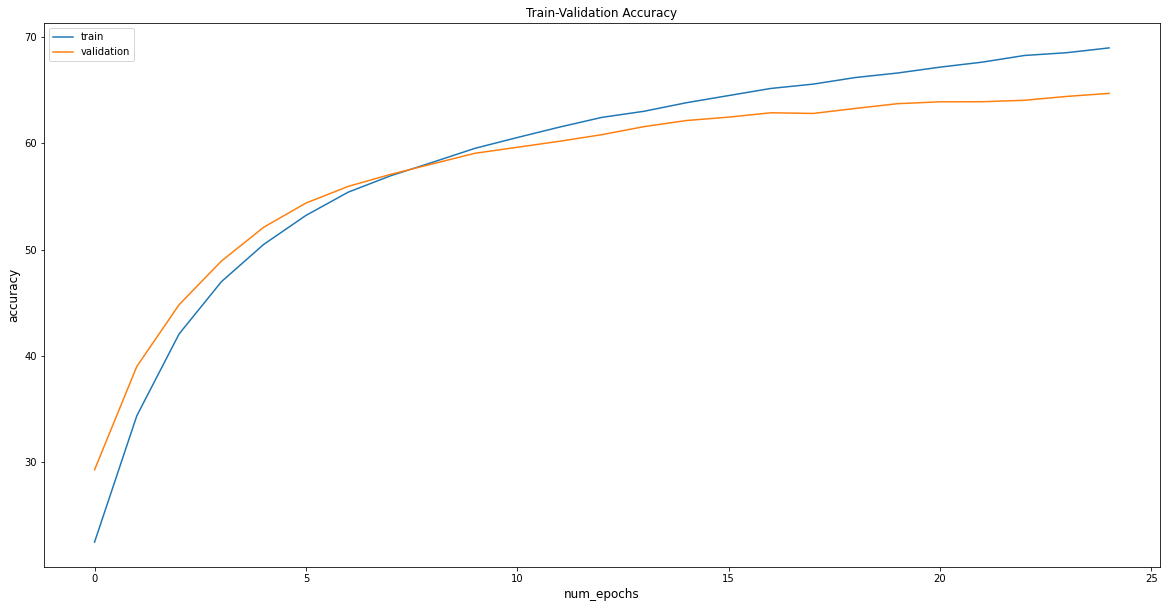

In [14]:
fig = plt.figure(figsize=(20,10))
plt.title("Train-Validation Accuracy")
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')

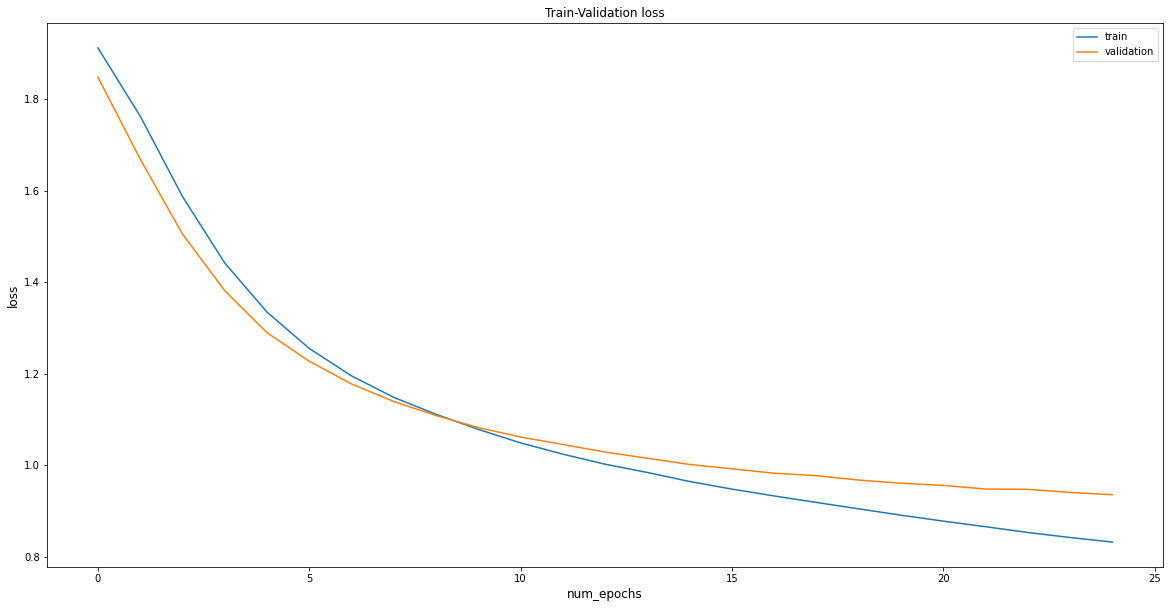

In [15]:
fig = plt.figure(figsize=(20,10))
plt.title("Train-Validation loss")
plt.plot(train_loss, label='train')
plt.plot(val_loss, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.legend(loc='best')